In [1]:
import torch
import os
import random
import numpy as np

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from dataset.utils import process_classification_dataset, load_classification_dataset

config = {
        'dataset': 'facebook_ct1', # 'infectious_ct1', #
        'hidden_size': 64,
        'rnn_layers': 5,
        'readout_layers': 1,
        'cell_type': 'lstm',
        'dim_red': 64,
        'add_self_loops': False,
        'verbose': True,
        'cat_states_layers': True,
        'weight_decay': 0,
        'step_size': 30,
        'gamma': 0.5
        }

# Select one GPU if more are available
os.environ["CUDA_VISIBLE_DEVICES"]='0'

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

c:\Users\mgphy\anaconda3\envs\koopman\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\mgphy\anaconda3\envs\koopman\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
# Fix cuda memory issue
dataset, states, node_states, node_labels = process_classification_dataset(config, "DynCRNN", device)

100%|██████████| 995/995 [18:14<00:00,  1.10s/it]


In [3]:
edge_indexes, _, _ = load_classification_dataset(config['dataset'], False)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

inputs, test_inputs, labels, test_labels = train_test_split(states.inputs[:,-1,:], dataset.targets, test_size=0.2, random_state=seed)

# Create the classifier
classifier = LogisticRegression(max_iter=5000, random_state=seed)

# Train the classifier
classifier.fit(inputs, labels)

# Test the classifier
y_pred = classifier.predict(test_inputs)

accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


# PCA per node

In [9]:
import importlib
import koopman.sindy

importlib.reload(koopman.sindy)

from koopman.sindy import SINDy

In [10]:
from koopman.sindy import SINDy
from einops import rearrange

idx = 0

Z = rearrange(node_states[idx], 't n f -> n t f')
edge_index = edge_indexes[idx]
k = 10
alpha = 1.0
emb = "PCA"

sindy = SINDy(Z, edge_index, k, alpha, emb)

In [11]:
K = sindy.fit()

In [5]:
from torch_sparse import SparseTensor

idx = 0

edge_index = torch.cat(edge_indexes[idx], dim=1)
edge_index = torch.unique(edge_index.T, dim=0).T

num_nodes = edge_index.max().item() + 1
adj_matrix = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(num_nodes, num_nodes))
adj_matrix = adj_matrix.to_dense()

In [6]:
from sklearn.decomposition import PCA
from einops import rearrange

node_states0 = rearrange(node_states[idx], 't n f -> n t f')

pca = PCA(n_components=10)
X = pca.fit_transform(rearrange(node_states0, 'n t f -> (n t) f'))
X = rearrange(X, '(n t) f -> n t f', n=num_nodes, t=node_states0.shape[1], f=10)
X = torch.from_numpy(X)

In [8]:
torch.nonzero(adj_matrix).size(0)

210

In [10]:
from koopman.sindy import sindy_library_adj

s = sindy_library_adj(X[:,:,:], adj_matrix)

In [10]:
X.shape

torch.Size([100, 106, 10])

In [11]:
s.shape

torch.Size([410, 106, 10])

In [12]:
from koopman.sindy import sindy_fit2

# s = rearrange(s, 'n t f -> (t n) f', n=s.shape[0], t=s.shape[1], f=10)

x = rearrange(s[:,:-1,:], 'n t f -> t (n f)')
y = rearrange(s[:num_nodes,1:,:], 'n t f -> t (n f)')

K = sindy_fit2(x, y, 1.0)

In [13]:
K.shape

(1000, 4100)

In [14]:
# Reconstructing the whole trajectory step by step
s_ = rearrange(s, 'n t f -> t (n f)', n=s.shape[0], t=s.shape[1], f=10)
s_rec = np.empty(shape=(s_.shape[0], num_nodes*10))

s_rec[0,:] = rearrange(s[:num_nodes,:,:], 'n t f -> t (n f)', n=num_nodes, t=s.shape[1], f=10)[0]
for n in range(1, s_.shape[0]):
    s_rec[n,:] = np.dot(s_rec[n-1,:], K)[:1000]

s_rec = rearrange(s_rec, 't (n f) -> n t f', n=num_nodes, f=10)

In [15]:
rel_e = [np.linalg.norm(s[:100,t,:] - s_rec[:,t,:], ord='fro', axis=(0,1))**2 / 
         np.linalg.norm(s[:100,t,:], ord='fro', axis=(0,1))**2 
         for t in range(s.shape[1])]

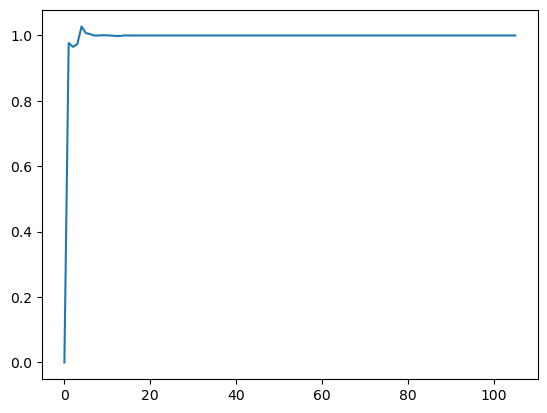

In [17]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(rel_e)

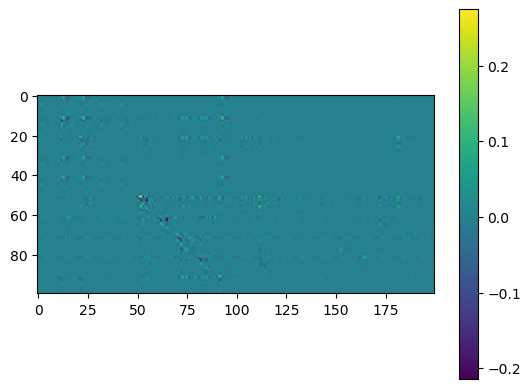

In [18]:
plt.imshow(K[:100,:200])
plt.colorbar()
plt.show()

In [19]:
K.shape

(1000, 4100)

Summing over the "F" dimension

In [20]:
# Reshape K into a 3D array with shape (num_blocks, 10, num_features)
num_blocks = K.shape[0] // 10
sum_K = np.array([np.sum(K[i*10:(i+1)*10], axis=0) for i in range(num_blocks)])

num_blocks = K.shape[1] // 10
sum_K = np.stack([np.sum(sum_K[:,i*10:(i+1)*10], axis=1) for i in range(num_blocks)], axis=1)
# K_reshaped = rearrange(K, '(n f) H -> n f H', n=num_nodes, f=10)

# sum_K = np.sum(K_reshaped, axis=1)

In [21]:
sum_K.shape

(100, 410)

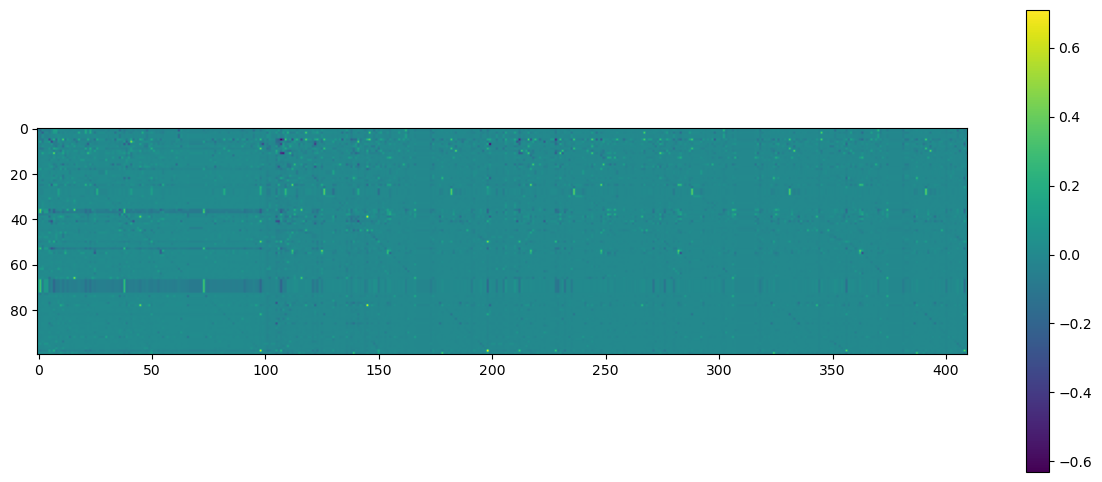

In [22]:
plt.figure(figsize=(15, 6))

plt.imshow(sum_K)
plt.colorbar()
plt.show()

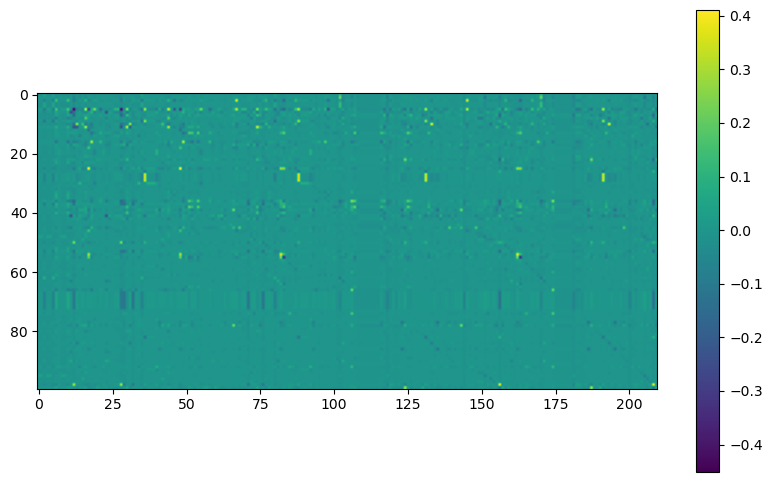

In [23]:
plt.figure(figsize=(10, 6))

plt.imshow(sum_K[:,200:])
plt.colorbar()
plt.show()

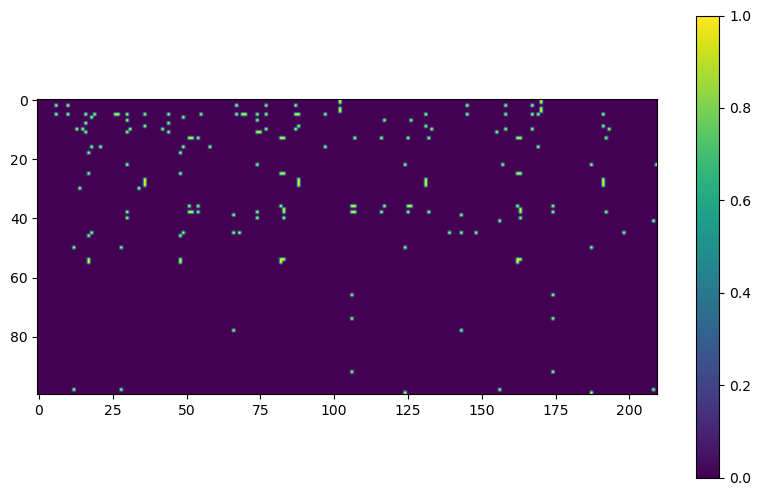

In [24]:
plt.figure(figsize=(10, 6))

plt.imshow((sum_K>0.1)[:,200:])
plt.colorbar()
plt.show()

In [71]:
sum_K[:,29]

array([-9.31561262e-03, -2.24877746e-03, -1.46045206e-02, -9.31561262e-03,
       -9.31561262e-03, -7.66372080e-03,  5.17674042e-02, -2.82437617e-02,
       -1.46840263e-02,  6.61649886e-05, -1.00309587e-02, -6.14475634e-03,
        3.34818349e-02,  4.30570731e-02, -6.99107008e-03,  1.13919275e-02,
       -1.63831980e-02,  7.87875918e-03, -5.07287941e-03,  3.20641084e-02,
        3.20641084e-02, -1.68683666e-03,  4.49828377e-03,  2.00239096e-02,
       -8.95393654e-03,  3.80202495e-02,  1.52916139e-02,  7.40433240e-02,
        7.40433240e-02,  7.40433240e-02,  6.85701275e-02,  1.08567947e-02,
       -7.54330770e-03,  1.68571325e-02, -1.00313024e-02, -1.31036081e-02,
        5.20741222e-03, -2.46409121e-02,  8.43202719e-03,  8.41591747e-04,
        2.37761643e-02, -1.55224141e-02,  1.46005331e-02,  2.35165566e-02,
        1.73590367e-02, -1.05789440e-02,  6.18931864e-02,  1.21553390e-02,
       -2.34269436e-02, -7.28920453e-04,  4.30315439e-02, -1.05695155e-02,
       -1.17374044e-02, -

In [78]:
# Get the indices that would sort the array based on magnitude
sorted_indices = np.argsort(np.abs(sum_K[:,29]))

# Sort the arguments of the array based on magnitude
sorted_args = np.arange(len(sum_K[:,29]))[sorted_indices]

print(sorted_args[-1:0:-1])

[28 27 29 83 30 46  6 56 77 13 50 25 82 12 19 20 91  7 98 79 37 76 40 43
 48 78 85 88 23 93 64 65 92 44 86 75 97 33 16 81 61 41 26 90 59  8  2 42
 57 35 94 60 47 52 66 55 58 15 31 45 51 74 34 10  3  4  0 24 38 54 99 17
  5 32 73 53 14 89 62 11 87 36 18 96 80 22  1 63 21 71 72 70 69 68 67 39
 49 95 84]


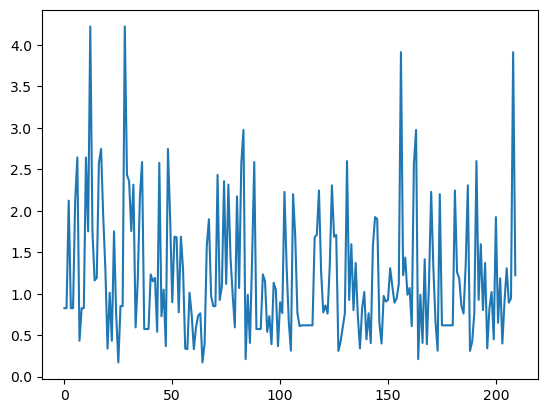

In [25]:
weights = np.abs(sum_K[:,200:]).sum(axis=0)
# weights = (sum_K>0.1)[:,200:].sum(axis=0)
# weights = sum_K[98]

plt.plot(weights)

In [26]:
idx = 0

edge_index = torch.cat(edge_indexes[idx], dim=1)
edge_index = torch.unique(edge_index.T, dim=0).T

In [27]:
node_weights = torch.abs(node_states0[:,-1,:]).max(axis=-1).values
# node_weights = sum_K[:,:100].diagonal()
# node_weights = np.abs(val_proj[:,-1])

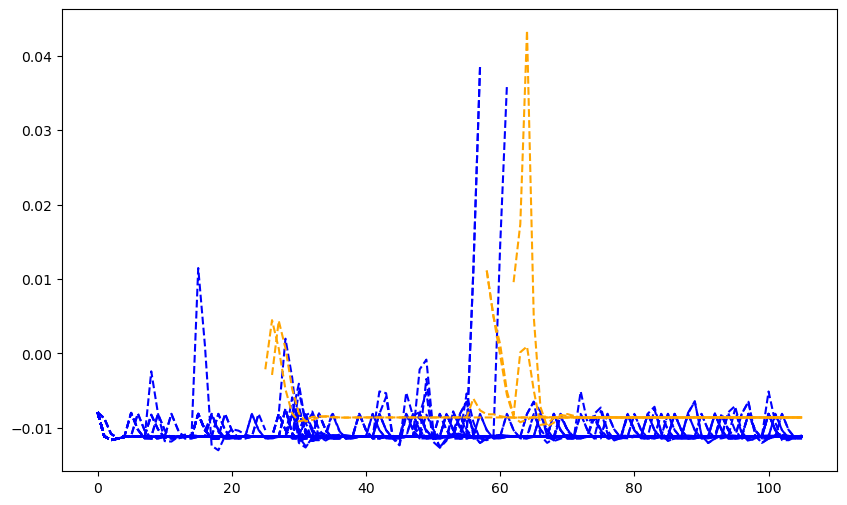

In [28]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6))

node_y = node_labels[0][:,:,0].numpy().T

proj = node_states0[:,:,0].numpy()

m = np.where(node_y.astype(bool), proj, np.NaN)
m_not = np.where(~node_y.astype(bool), proj, np.NaN)
# m_gt = np.where((nodes_gt[0].T != 0).numpy().astype(bool), val_proj, np.NaN)

for l in range(m_not.shape[0]):
    axs.plot(m_not[l], c='b', label="class 0", linestyle='dashed')
for n in range(m.shape[0]):
    axs.plot(m[n], c='orange', label="class 1", linestyle='dashed')
# for k in range(m_gt.shape[0]):
#     axs.plot(m_gt[k], c='r', label="GT", linestyle='dotted')
# axs.set_title(f'Projection on eig {i}')

plt.show()

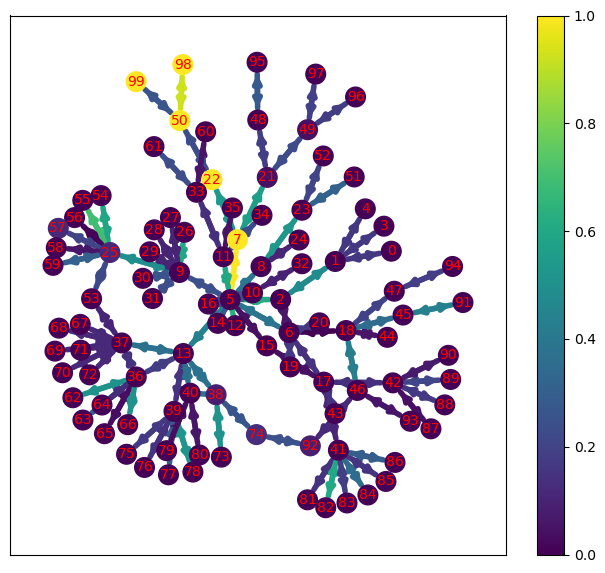

In [30]:
import networkx as nx

import matplotlib.pyplot as plt

# Create an empty graph
plt.figure(figsize=(8, 7))
G = nx.DiGraph()

# Add edges
G.add_edges_from(edge_index.T.tolist())

# Plot the graph
pos = nx.kamada_kawai_layout(G)
cmap = matplotlib.colormaps.get_cmap('viridis')
norm = plt.Normalize(min(node_weights), max(node_weights))
colors = [cmap(norm(w)) for w in node_weights]
pax = nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=200)
norm = plt.Normalize(min(weights), max(weights))
colors = [cmap(norm(w)) for w in weights]
# im = nx.draw(G, pos=pos, node_color='lightblue', edge_color=colors, width=2)
nx.draw_networkx_edges(G, pos, edge_color=colors, width=4)
n_labels = {i: str(i) for i in range(num_nodes)}
nx.draw_networkx_labels(G, pos, n_labels, font_size=10, font_color='r')

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(weights), vmax=max(weights)))
# sm._A = []
plt.colorbar(pax)

# Show the plot
plt.show()

In [31]:
from dataset.utils import ground_truth

nodes_gt, node_sums_gt, times_gt = ground_truth("facebook_ct1")

995it [00:06, 147.39it/s]


In [32]:
nodes_gt0 = nodes_gt[0]

In [33]:
# Create a mask for edge_index
edge_gt = torch.zeros(edge_index.size(1), dtype=torch.int)

# Iterate over each edge in edge_index
for i in range(edge_index.size(1)):
    src, tgt = edge_index[0, i], edge_index[1, i]
    
    # Check if both source and target nodes are in nodes_gt0
    if src in torch.where(nodes_gt0[-1])[0] and tgt in torch.where(nodes_gt0[-1])[0]:
        edge_gt[i] = 1

In [34]:
from sklearn.metrics import roc_auc_score

# Compute the AUC score
# discrete_weights = np.zeros(weights.shape)
# discrete_weights[weights>1.5] = 1
auc_score = roc_auc_score(edge_gt, weights)

print("AUC Score:", auc_score)

AUC Score: 0.7846534653465347


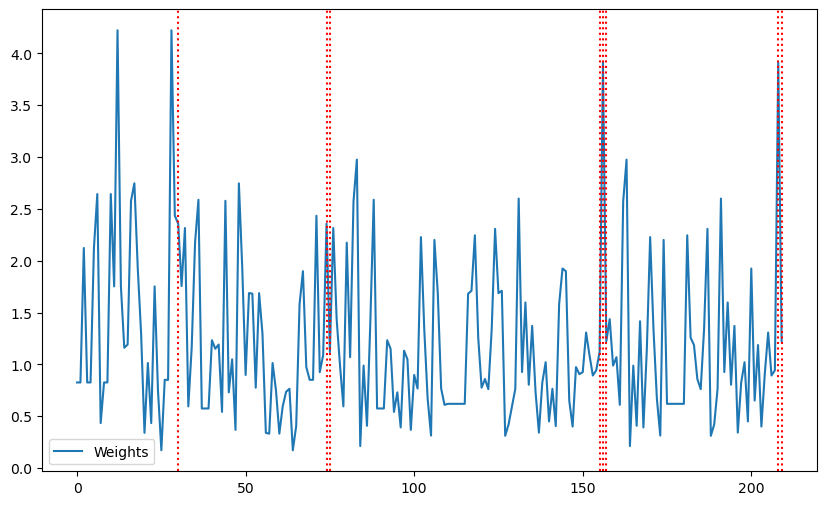

In [35]:
plt.figure(figsize=(10, 6))

plt.plot(weights, label='Weights')

# Plotting the ground truth edges as vertical dotted lines
for i in range(len(edge_gt)):
    if edge_gt[i] == 1:
        plt.axvline(x=i, color='r', linestyle='dotted')

plt.legend()
plt.show()

Compute AUC on the whole dataset

In [29]:
dataset.targets[0]

1.0

In [30]:
node_states[0].shape

torch.Size([106, 100, 256])

In [36]:
from torch_sparse import SparseTensor
from sklearn.decomposition import PCA
from einops import rearrange
from sklearn.metrics import roc_auc_score

from DMD.sindy import sindy_library_adj, sindy_fit2
from dataset.utils import ground_truth

nodes_gt, node_sums_gt, times_gt = ground_truth("facebook_ct1")
aucs = []

for idx in range(len(edge_indexes)):
    
    if dataset.targets[idx] == 0:
        continue

    # Build adj matrix
    edge_index = torch.cat(edge_indexes[idx], dim=1)
    edge_index = torch.unique(edge_index.T, dim=0).T

    num_nodes = edge_index.max().item() + 1
    adj_matrix = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(num_nodes, num_nodes))
    adj_matrix = adj_matrix.to_dense()

    # Reduce the dimensionality of the node states 
    node_states_i = rearrange(node_states[idx], 't n f -> n t f')
    pca = PCA(n_components=10)
    X = pca.fit_transform(rearrange(node_states_i, 'n t f -> (n t) f'))
    X = rearrange(X, '(n t) f -> n t f', n=num_nodes, t=node_states_i.shape[1], f=10)
    X = torch.from_numpy(X)

    # Apply SINDy
    s = sindy_library_adj(X, adj_matrix)
    x = rearrange(s[:,:-1,:], 'n t f -> t (n f)')
    y = rearrange(s[:num_nodes,1:,:], 'n t f -> t (n f)')
    K = sindy_fit2(x, y, 1.0)

    # Remove "F" dimension
    num_blocks = K.shape[0] // 10
    sum_K = np.array([np.sum(K[i*10:(i+1)*10], axis=0) for i in range(num_blocks)])
    num_blocks = K.shape[1] // 10
    sum_K = np.stack([np.sum(sum_K[:,i*10:(i+1)*10], axis=1) for i in range(num_blocks)], axis=1)

    # Compute the weights
    weights = np.abs(sum_K[:,2*num_nodes:]).sum(axis=0)

    # Ground truth
    edge_gt = torch.zeros(edge_index.size(1), dtype=torch.int)
    for i in range(edge_index.size(1)):
        src, tgt = edge_index[0, i], edge_index[1, i]
        if src in torch.where(nodes_gt[idx][-1])[0] and tgt in torch.where(nodes_gt[idx][-1])[0]:
            edge_gt[i] = 1
    
    # Compute the AUC score
    if torch.sum(edge_gt) == 0:
        print("No ground truth edges: ", idx)
        continue
    auc_score = roc_auc_score(edge_gt, weights)
    aucs.append(auc_score)

aucs = np.array(aucs)

995it [00:06, 146.02it/s]


No ground truth edges:  50
No ground truth edges:  180
No ground truth edges:  184
No ground truth edges:  202
No ground truth edges:  206
No ground truth edges:  232
No ground truth edges:  236
No ground truth edges:  264
No ground truth edges:  276
No ground truth edges:  284
No ground truth edges:  294
No ground truth edges:  302
No ground truth edges:  486
No ground truth edges:  500
No ground truth edges:  506
No ground truth edges:  508
No ground truth edges:  524
No ground truth edges:  564
No ground truth edges:  574
No ground truth edges:  576
No ground truth edges:  660
No ground truth edges:  682
No ground truth edges:  686
No ground truth edges:  734
No ground truth edges:  754
No ground truth edges:  826
No ground truth edges:  830
No ground truth edges:  838
No ground truth edges:  858
No ground truth edges:  868
No ground truth edges:  872
No ground truth edges:  908
No ground truth edges:  926
No ground truth edges:  958
No ground truth edges:  980
No ground truth edges

In [37]:
aucs.mean()

0.6252264750932375

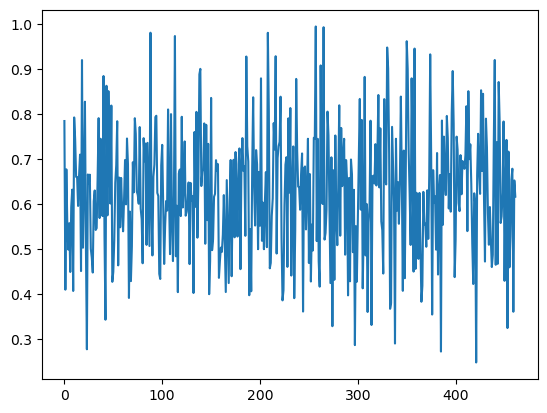

In [38]:
plt.plot(aucs)

Taking each components of the "F" dimension separately

In [34]:
from koopman.dmd import KANN

dim_red = 10
method = 'PCA'

# compute local Koopman operator
kann_ = KANN(node_states0, k=dim_red, emb=method)

K0 = kann_.compute_KOP()
E, V = np.linalg.eig(K0)

# sort eigenvalues and eigenvectors
idx = np.argsort(np.abs(E))[::-1]
E = E[idx]
V = V[:, idx]

vr = V.real

# Calculate the projection
nodes_red = kann_.emb_engine.transform(rearrange(node_states0, 'n t f -> (n t) f'))
nodes_red = rearrange(nodes_red, '(n t) f -> n t f', n = node_states0.shape[0], t=node_states0.shape[1], f=dim_red)
nodes_proj = np.dot(nodes_red, vr)

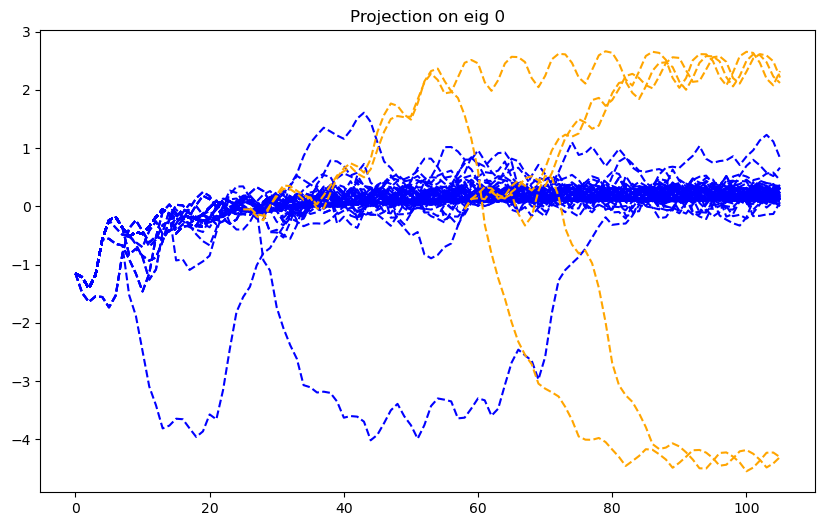

In [35]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6))

node_y = node_labels[0][:,:,0].numpy().T

i=0

val_proj = nodes_proj[:,:,i]

m = np.where(node_y.astype(bool), val_proj, np.NaN)
m_not = np.where(~node_y.astype(bool), val_proj, np.NaN)
# m_gt = np.where((nodes_gt[0].T != 0).numpy().astype(bool), val_proj, np.NaN)

for l in range(m_not.shape[0]):
    axs.plot(m_not[l], c='b', label="class 0", linestyle='dashed')
for n in range(m.shape[0]):
    axs.plot(m[n], c='orange', label="class 1", linestyle='dashed')
# for k in range(m_gt.shape[0]):
#     axs.plot(m_gt[k], c='r', label="GT", linestyle='dotted')
axs.set_title(f'Projection on eig {i}')

# idx_t = np.where(times_gt[0] != 0)[0]
# for j in idx_t:
#     axs.axvline(x=j, color='b', linestyle='dotted')
    
# Show the plot
plt.show()

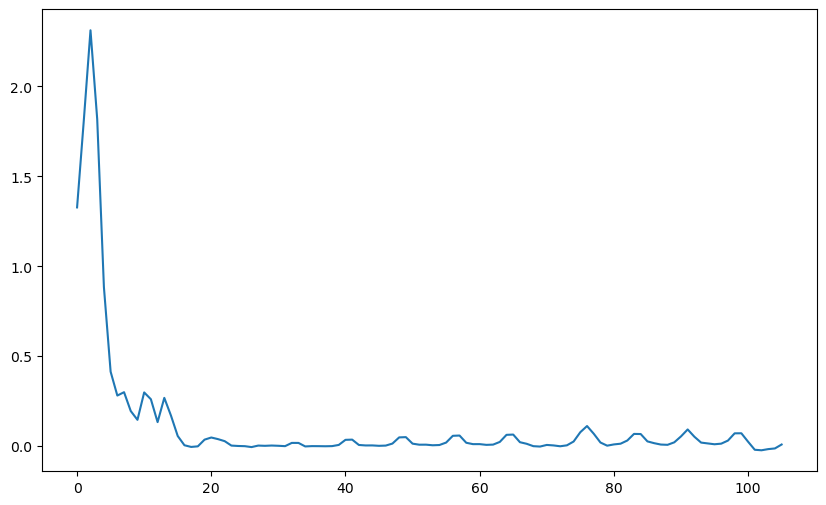

In [139]:
plt.figure(figsize=(10, 6))
plt.plot(val_proj[21,:]*val_proj[48,:])

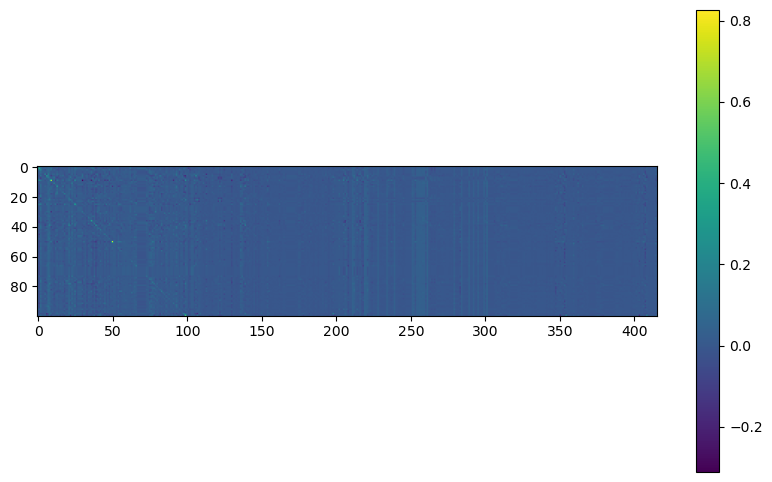

In [36]:
nodes_proj0 = nodes_proj[:,:,0]
nodes_proj0 = nodes_proj0[:,:,np.newaxis]

s0 = sindy_library_adj(torch.from_numpy(nodes_proj0), adj_matrix)

x0 = rearrange(s0[:,:-1,:], 'n t f -> t (n f)')
y0 = rearrange(s0[:num_nodes,1:,:], 'n t f -> t (n f)')

K_F = sindy_fit2(x0, y0, 1.0)

plt.figure(figsize=(10, 6))
plt.imshow(K_F)
plt.colorbar()
plt.show()

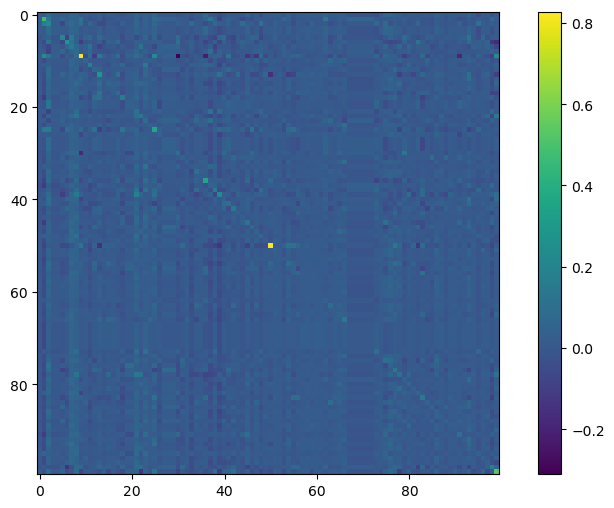

In [37]:
plt.figure(figsize=(10, 6))
plt.imshow(K_F[:,:100])
plt.colorbar()
plt.show()

In [38]:
np.where(np.abs(K_F[:,:100].sum(axis=0))>2.5)

(array([ 2,  7,  8, 21, 23, 25, 76, 77, 93, 99]),)

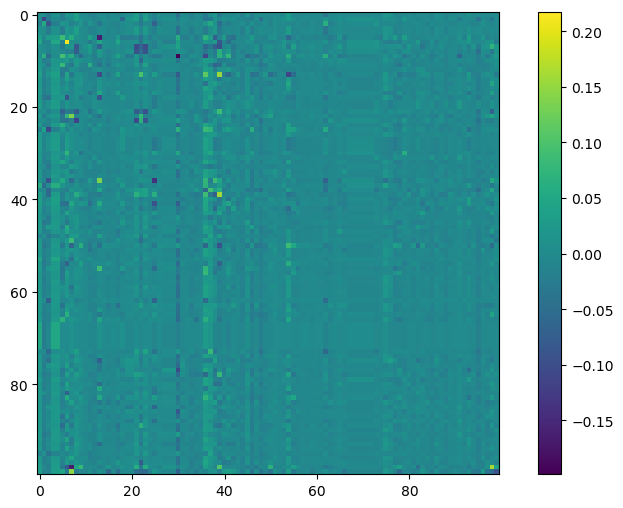

In [39]:
plt.figure(figsize=(10, 6))
plt.imshow(K_F[:,100:200])
plt.colorbar()
plt.show()

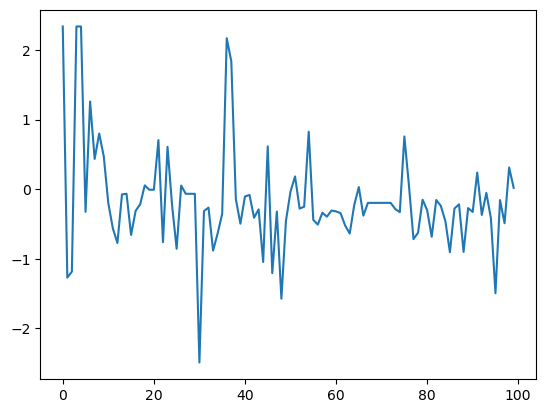

In [40]:
plt.plot(K_F[:,100:200].sum(axis=0))

In [41]:
np.where(np.abs(K_F[:,100:200].sum(axis=0))>1)

(array([ 0,  1,  2,  3,  4,  6, 30, 36, 37, 44, 46, 48, 95]),)

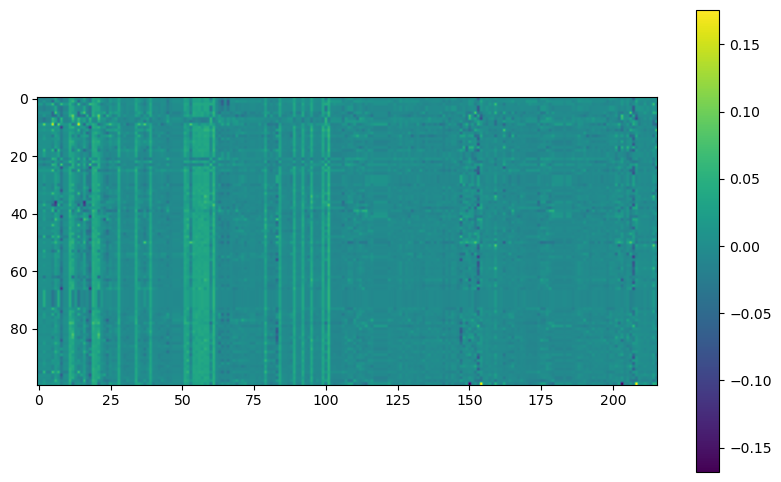

In [42]:
plt.figure(figsize=(10, 6))
plt.imshow(K_F[:,200:])
plt.colorbar()
plt.show()

In [43]:
# c_idx = 0

# num_blocks = K.shape[0] // 10
# K_F = np.array([K[i*10 + c_idx] for i in range(num_blocks)])

# num_blocks = K.shape[1] // 10
# K_F = np.stack([K_F[:,i*10 + c_idx] for i in range(num_blocks)], axis=1)

# plt.figure(figsize=(10, 6))
# plt.imshow(K_F)
# plt.colorbar()
# plt.show()

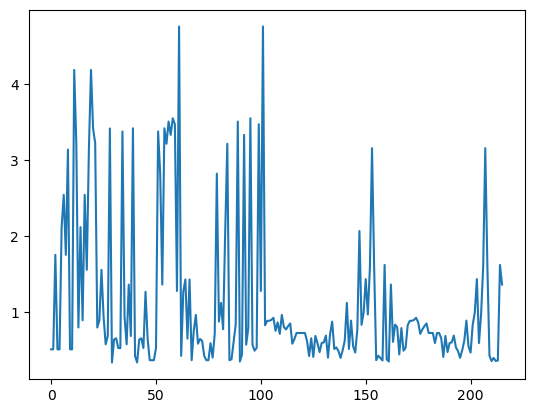

In [44]:
weights = np.abs(K_F[:,200:]).sum(axis=0)

plt.plot(weights)

In [185]:
node_weights = np.abs(nodes_proj0[:,-1,0])

/tmp/ipykernel_126068/3854630706.py:26: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=colors, width=4)


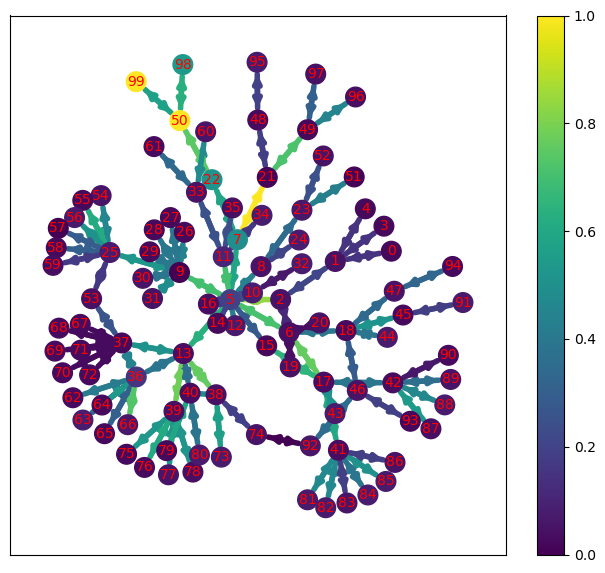

In [186]:
idx = 0

edge_index = torch.cat(edge_indexes[idx], dim=1)
edge_index = torch.unique(edge_index.T, dim=0).T

# Create an empty graph
plt.figure(figsize=(8, 7))
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(range(num_nodes))
n_labels = {i: str(i) for i in range(num_nodes)}

# Add edges
G.add_edges_from(edge_index.T.tolist())

# Plot the graph
pos = nx.kamada_kawai_layout(G)
cmap = matplotlib.colormaps.get_cmap('viridis')
norm = plt.Normalize(min(node_weights), max(node_weights))
colors = [cmap(norm(w)) for w in node_weights]
# im = nx.draw(G, pos=pos, node_color='lightblue', edge_color=colors, width=2)
pax = nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=200)
norm = plt.Normalize(min(weights), max(weights))
colors = [cmap(norm(w)) for w in weights]
nx.draw_networkx_edges(G, pos, edge_color=colors, width=4)
n_labels = {i: str(i) for i in range(num_nodes)}
nx.draw_networkx_labels(G, pos, n_labels, font_size=10,font_color='r')

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(weights), vmax=max(weights)))
# sm._A = []
plt.colorbar(pax)

# Show the plot
plt.show()

In [199]:
from torch_sparse import SparseTensor
from einops import rearrange
from sklearn.metrics import roc_auc_score

from DMD.sindy import sindy_library_adj, sindy_fit2
from dataset.utils import ground_truth

nodes_gt, node_sums_gt, times_gt = ground_truth("facebook_ct1")
aucs = []

for idx in range(len(edge_indexes)):
    
    if dataset.targets[idx] == 0:
        continue

    # Ground truth
    edge_index = torch.cat(edge_indexes[idx], dim=1)
    edge_index = torch.unique(edge_index.T, dim=0).T

    edge_gt = torch.zeros(edge_index.size(1), dtype=torch.int)
    for i in range(edge_index.size(1)):
        src, tgt = edge_index[0, i], edge_index[1, i]
        if src in torch.where(nodes_gt[idx][-1])[0] and tgt in torch.where(nodes_gt[idx][-1])[0]:
            edge_gt[i] = 1
    if torch.sum(edge_gt) == 0:
        print("No ground truth edges: ", idx)
        continue

    # Build adj matrix
    num_nodes = edge_index.max().item() + 1
    adj_matrix = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(num_nodes, num_nodes))
    adj_matrix = adj_matrix.to_dense()

    # Reduce the dimensionality of the node states 
    node_states_i = rearrange(node_states[idx], 't n f -> n t f')
    dim_red = 10
    method = 'PCA'
    kann_ = KANN(node_states0, k=dim_red, emb=method)
    K0 = kann_.compute_KOP()
    E, V = np.linalg.eig(K0)
    # sort eigenvalues and eigenvectors
    idx = np.argsort(np.abs(E))[::-1]
    E = E[idx]
    V = V[:, idx]
    vr = V.real
    # Calculate the projection
    nodes_red_i = kann_.emb_engine.transform(rearrange(node_states_i, 'n t f -> (n t) f'))
    nodes_red_i = rearrange(nodes_red_i, '(n t) f -> n t f', n = node_states_i.shape[0], t=node_states_i.shape[1], f=dim_red)
    nodes_proj_i = np.dot(nodes_red_i, vr)
    X = torch.from_numpy(nodes_proj_i[:,:,0])
    X = X[:,:,np.newaxis]

    # Apply SINDy
    s = sindy_library_adj(X, adj_matrix)
    x = rearrange(s[:,:-1,:], 'n t f -> t (n f)')
    y = rearrange(s[:num_nodes,1:,:], 'n t f -> t (n f)')
    K = sindy_fit2(x, y, 1.0)

    # Compute the weights
    weights = np.abs(K[:,2*num_nodes:]).sum(axis=0)

    # Compute the AUC score
    auc_score = roc_auc_score(edge_gt, weights)
    aucs.append(auc_score)

aucs = np.array(aucs)

995it [00:07, 135.47it/s]


No ground truth edges:  50
No ground truth edges:  180
No ground truth edges:  184
No ground truth edges:  202
No ground truth edges:  206
No ground truth edges:  232
No ground truth edges:  236
No ground truth edges:  264
No ground truth edges:  276
No ground truth edges:  284
No ground truth edges:  294
No ground truth edges:  302
No ground truth edges:  486
No ground truth edges:  500
No ground truth edges:  506
No ground truth edges:  508
No ground truth edges:  524
No ground truth edges:  564
No ground truth edges:  574
No ground truth edges:  576
No ground truth edges:  660
No ground truth edges:  682
No ground truth edges:  686
No ground truth edges:  734
No ground truth edges:  754
No ground truth edges:  826
No ground truth edges:  830
No ground truth edges:  838
No ground truth edges:  858
No ground truth edges:  868
No ground truth edges:  872
No ground truth edges:  908
No ground truth edges:  926
No ground truth edges:  958
No ground truth edges:  980
No ground truth edges

In [200]:
aucs.mean()

0.6009207701365524

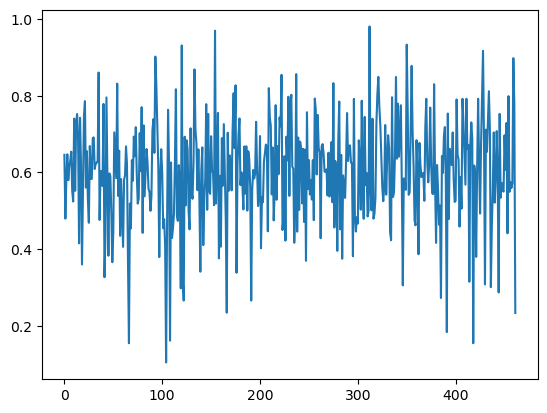

In [201]:
plt.plot(aucs)

In [46]:
# E, V = np.linalg.eig(K)

# # sort eigenvalues and eigenvectors
# idx = np.argsort(np.abs(E))[::-1]
# E = E[idx]
# V = V[:, idx]

# cmap = matplotlib.colormaps.get_cmap('viridis')

# plt.figure(figsize=(5,5))
# plt.scatter(E.real, E.imag, c=idx, cmap=cmap)
# circle = plt.Circle((0, 0), 1, color='r', fill=False)
# plt.gca().add_patch(circle)
# plt.ylabel('Imaginary') 
# plt.xlabel('Real')
# plt.show()

In [47]:
# (np.abs(E)>0.9).sum()